# Topic Model Analysis

Todo: 1. industry : cusip to naics mapping 2. Topic evloution

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

from compute_lda import *
from manage_path import *
#from lda_analysis import *

#import plotly
#plotly.offline.init_notebook_mode(connected=True) 
#import plotly.graph_objs as go
#import plotly.io as pio
from itertools import repeat

import multiprocessing
from collections import deque

#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from collections import OrderedDict

## Topic Evolution
1. Dc_v1: 1 document for buy and sell, per dealer, per day.
2. Dc_v2: 1 document for buy and 1 document for sell, per dealer, per day.
3. Dc_v3: Either DC_v1 or DC_v2 without the 2 (4) documents representing the Source_seller and Source_buyer.
4. Tc_v1: 1 document for (buyer,seller,year)

In [2]:
result_directory = get_result_directory()
get_document_item_vectorize = np.vectorize(get_document_item)
#topic_matrix['dealer'] = pd.Series(list(zip(get_document_item_vectorize(topic.index,0),get_document_item_vectorize(topic.index,1)))).values

### Dc_v4

In [3]:
df = pd.read_csv(result_directory/'Dc_v4_75topics.csv',index_col=0)

In [4]:
df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,66,67,68,69,70,71,72,73,74,75
"10,2014-10-16,StC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.551516,NaN,NaN,NaN,NaN
"10,2014-11-21,StC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.502222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"10,2015-02-25,StC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['dealer'] = pd.Series(list(zip(get_document_item_vectorize(df.index,0),get_document_item_vectorize(df.index,2)))).values
df.index = pd.to_datetime(get_document_item_vectorize(df.index,1))

In [6]:
df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,67,68,69,70,71,72,73,74,75,dealer
2014-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.551516,NaN,NaN,NaN,NaN,"(10, StC)"
2014-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.502222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(10, StC)"
2015-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(10, StC)"


### topicXtime_sum

In [7]:
df_topicXtime_sum = df.groupby(by=df.index).sum()

In [8]:
#pd.DataFrame(preprocessing.normalize(df_topicXtime_sum,axis=0),index=df_topicXtime_sum.index,columns=df_topicXtime_sum.columns).sum()

### Entropy
-Sum(p_i * log(p_i)) where p_i is the normalized p such that Sum(p_i)=1

In [9]:
p_i = df_topicXtime_sum.apply(lambda x: x / x.sum())

In [10]:
df_topicXtime_sum_entropy = (p_i * np.log(p_i)).replace([np.inf, -np.inf], np.nan).sum() * -1

/home/raymond/anaconda3/envs/topicModeling/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


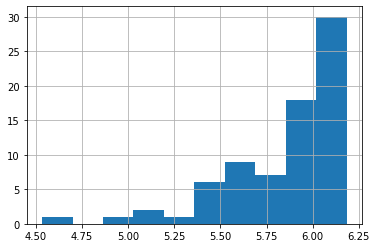

In [11]:
df_topicXtime_sum_entropy.hist()

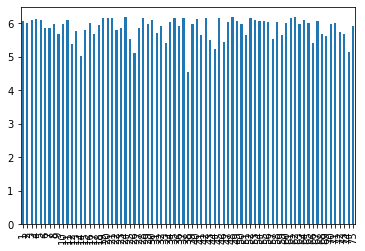

In [21]:
df_topicXtime_sum_entropy.plot.bar()

In [12]:
df_topicXtime_sum_entropy.iloc[30:40]

31    5.712220
32    5.912395
33    5.405208
34    6.036659
35    6.142176
36    5.899180
37    6.162622
38    4.535457
39    5.986962
40    6.115024
dtype: float64

In [13]:
#Dc_v3.groupby(by=Dc_v3.index).sum().to_csv('Dc_v3_50topics_topicXtime_sum.csv')

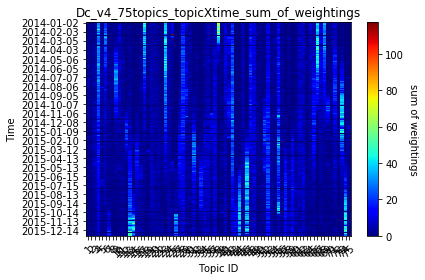

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(df_topicXtime_sum,plt.get_cmap("jet"),aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(len(df_topicXtime_sum.columns)))
ax.set_yticks(np.arange(0,len(df_topicXtime_sum.index.date),22))
# ... and label them with the respective list entries
ax.set_xticklabels(df_topicXtime_sum.columns)
ax.set_yticklabels(df_topicXtime_sum.index.date[::22])
# Set axis labels
ax.set_xlabel('Topic ID', fontsize=10)
ax.set_ylabel('Time', fontsize=10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Set color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("sum of weightings", rotation=-90, va="bottom")

ax.set_title("Dc_v4_75topics_topicXtime_sum_of_weightings")
fig.tight_layout()
plt.show()
fig.savefig('Dc_v4_75topics_topicXtime_sum_of_weightings.png',dpi=300)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(preprocessing.minmax_scale(df_topicXtime_sum,feature_range=(0, 10)),plt.get_cmap("jet"),aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(0,len(df_topicXtime_sum.columns),10))
ax.set_yticks(np.arange(0,len(df_topicXtime_sum.index.date),22))
# ... and label them with the respective list entries
ax.set_xticklabels(df_topicXtime_sum.columns[::10])
ax.set_yticklabels(df_topicXtime_sum.index.date[::22])
# Set axis labels
ax.set_xlabel('Topic ID', fontsize=10)
ax.set_ylabel('Time', fontsize=10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Set color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("sum of weightings scale to [0,10]", rotation=-90, va="bottom")

ax.set_title("Dc_v4_75topics_topicXtime_sum_of_weightings_with_scaling")
fig.tight_layout()
plt.show()
fig.savefig('Dc_v4_75topics_topicXtime_sum_of_weightings_with_scaling.png',dpi=300)

### topicXtime_count

In [ ]:
df_topicXtime_count = df.groupby(by=df.index).count().drop('dealer',axis=1)#[Dc_v3.columns[0:2]]

In [ ]:
#Dc_v3.groupby(by=Dc_v3.index).count().to_csv('Dc_v3_50topics_topicXtime_count.csv')

In [ ]:
#subset=[2,5,6,8,13,42,44,46,49,61,65,69,70,71,72,73,74,75]
#df_topicXtime_count = df_topicXtime_count[[str(x) for x in subset]]

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(df_topicXtime_count,plt.get_cmap("jet"),aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(0,len(df_topicXtime_count.columns),10))
ax.set_yticks(np.arange(0,len(df_topicXtime_count.index.date),22))
# ... and label them with the respective list entries
ax.set_xticklabels(df_topicXtime_count.columns[::10])
ax.set_yticklabels(df_topicXtime_count.index.date[::22])
# Set axis labels
ax.set_xlabel('Topic ID', fontsize=10)
ax.set_ylabel('Time', fontsize=10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Set color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("count of documents", rotation=-90, va="bottom")

ax.set_title("Dc_v4_75topics_topicXtime_count_of_documents")
fig.tight_layout()
plt.show()
fig.savefig('Dc_v4_75topics_topicXtime_count_of_documents.png',dpi=300)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(preprocessing.minmax_scale(df_topicXtime_count,feature_range=(0, 10)),plt.get_cmap("jet"),aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(0,len(df_topicXtime_count.columns),10))
ax.set_yticks(np.arange(0,len(df_topicXtime_count.index.date),22))
# ... and label them with the respective list entries
ax.set_xticklabels(df_topicXtime_count.columns[::10])
ax.set_yticklabels(df_topicXtime_count.index.date[::22])
# Set axis labels
ax.set_xlabel('Topic ID', fontsize=10)
ax.set_ylabel('Time', fontsize=10)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Set color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("count of documents with scaling to [0,10]", rotation=-90, va="bottom")

ax.set_title("Dc_v4_75topics_topicXtime_count_of_documents")
fig.tight_layout()
plt.show()
fig.savefig('Dc_v4_75topics_topicXtime_count_of_documents_with_scaling.png',dpi=300)

In [ ]:
df_topicXtime_sum.to_csv("Dc_v4_75topics_topicXtime_sum.csv")
df_topicXtime_count.to_csv("Dc_v4_75topics_topicXtime_count.csv")

In [ ]:
df_topicXtime_count.sum().describe()

In [ ]:
df_topicXtime_count.sum(axis=1).describe()

### topicXtime heatmap

#### Try Plotly

In [ ]:
#ax = sns.heatmap(topic_matrix.values.tolist(),vmin=0,vmax=1,center=0.5)

In [ ]:
count_matrix = topic_matrix.groupby(["dealer"]).count()

In [ ]:
summary = topic_matrix.describe().T

In [ ]:
summary['mean'].plot()

In [ ]:
def get_dealer_by_ID(matrix,dealer_id,matrix_name):
    result = matrix.loc[matrix['dealer'] == dealer_id].copy().drop(labels='dealer',axis=1)
    return (result,dealer_id,matrix_name)

In [ ]:
dealer_df_list = list(map(lambda x: get_dealer_by_ID(topic_matrix,x,"Dc_v1"),list(topic_matrix['dealer'].unique())))
len(dealer_df_list)

In [ ]:
#deque(map(topicXtime,dealer_df_list))

In [ ]:
pio.orca.config
plotly.io.orca.status

cpu_cores = multiprocessing.cpu_count() - 1
pool = multiprocessing.Pool(cpu_cores)
pool.map(topicXtime_plotly_parallel,dealer_df_list)
pool.close()

#### Try mapplotlib

In [ ]:
cpu_cores = int(multiprocessing.cpu_count()/2) -1
pool = multiprocessing.Pool(cpu_cores)

In [ ]:
pool.starmap(topicXtime_matplotlib,dealer_df_list)
pool.close()

#### Try Seaborn

In [ ]:
sns.set()

In [ ]:
month_list = list(OrderedDict.fromkeys(dealer_df_list[0][0].index.strftime('%Y-%m')))

In [ ]:
ax = sns.heatmap(dealer_df_list[0][0].T.values,vmin=0,vmax=1,center=0.5,xticklabels=[0,50,100,150,200,250],yticklabels=month_list)

num_x_ticks = 5
# the index of the position of yticks
xticks = np.linspace(0, len(dealer_df_list[0][0].columns) - 1, num_x_ticks, dtype=np.int)

num_y_ticks = len(month_list)
# the index of the position of yticks
yticks = np.linspace(0, len(dealer_df_list[0][0].index) - 1, num_y_ticks, dtype=np.int)

#ax.set_xticks(xticks)
#ax.set_yticks(yticks)
ax.set_autoscaley_on(True)
ax.set_title('test')

In [ ]:
import matplotlib.dates as mdates
ax = sns.heatmap(dealer_df_list[0][0].T,vmin=0,vmax=1,center=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_minor_locator(mdates.DayLocator())

#ax.set_xlim(dealer_df_list[0][0].index[0], dealer_df_list[0][0].index[-1])
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

figure = ax.get_figure()
figure.savefig('test.png', dpi=400)

In [ ]:
ax = sns.heatmap(dealer_df_list[0][0].T,vmin=0,vmax=1,center=0.5)

In [ ]:
dealer_df_list[0][0].index[-1]

In [ ]:
yticks

In [ ]:
xticks

In [ ]:
figure = ax.get_figure()
figure.savefig('test.png', dpi=400)
#figure.savefig('test.svg', format="svg")

In [ ]:
ax.fig.autofmt_ydate()

In [ ]:
topic_matrix.corr().head()

## Topic Terms Distribution
Below is the topic terms ditrutbution demo. Since we already got Document X Topics, we want to have a Topic X Terms too.

In [ ]:
num_topics = 50
model = load_model('Dc_v3',num_topics)

In [ ]:
topic_terms_distribution = pd.DataFrame(model.get_topics())

In [ ]:
topic_terms_distribution.head()

## Industy Analysis

In [ ]:
data_path = get_pickle_directory() / 'TRACE2014_jinming.pkl'
data = pd.read_pickle(data_path)

In [ ]:
data.columns

In [ ]:
print("We have {} rows of data".format(data.shape[0]))

In [ ]:
def fix_NAICS_Code(NAICS_Code):
    "Fix the problem that FISD omits 0 if NAICS_Code ends with 0"
    if len(str(NAICS_Code))==5:
        NAICS_Code = NAICS_Code+'0'
    return NAICS_Code
fix_NAICS_Code_vectorize = np.vectorize(fix_NAICS_Code)
data['NAICS_CODE'] = fix_NAICS_Code_vectorize(data['NAICS_CODE'].values)

In [ ]:
data = data[['BOND_SYM_ID', 'INDUSTRY_GROUP', 'INDUSTRY_CODE', 'PARENT_ID', 'NAICS_CODE','SIC_CODE']].copy()

In [ ]:
data['INDUSTRY_CODE'].value_counts().plot.pie()

In [ ]:
# Get the NAICS_code lookup table
NAICS_code_path = get_dataset_directory() / 'NAICS_Code_Lookup.csv'
NAICS_code = pd.read_csv(NAICS_code_path,dtype={'Code':str,'Description':str})

In [ ]:
# Group by BOND_SYM_ID and NAICS_CODE of 
NAICS_CODE_count = data['NAICS_CODE'].value_counts()
# Series to DataFrame
NAICS_CODE_count = NAICS_CODE_count.to_frame(name='count')

In [ ]:
NAICS_code_total = NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)
NAICS_code_total['percentage'] = NAICS_code_total['count']/data.shape[0]

In [ ]:
NAICS_code_total

In [ ]:
(NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)['count']/data.shape[0]).sum()

In [ ]:
data.groupby(by=['NAICS_CODE'])['BOND_SYM_ID'].nunique().sort_values(ascending=False).head()

In [ ]:
data.groupby(by=['BOND_SYM_ID'])

In [ ]:
Bond_X_Industry = data.drop_duplicates(['BOND_SYM_ID'])

In [ ]:
Bond_X_Industry.sort_values(by=['BOND_SYM_ID']).head()

## Individual Check

## Convergence Test

In [ ]:
import re
import matplotlib.pyplot as plt
def convergence_likelyhood(model_name,num_topics):
    p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
    matches = [p.findall(l) for l in open('../LDAModel/{}_{}topics.log.txt'.format(model_name,num_topics))]
    matches = [m for m in matches if len(m) > 0]
    tuples = [t[0] for t in matches]
    perplexity = [float(t[1]) for t in tuples]
    liklihood = [float(t[0]) for t in tuples]
    iter = list(range(0,len(tuples)*10,10))
    plt.plot(iter,liklihood,c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("iteration")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.savefig("{}_{}topics.pdf".format(model_name,num_topics))
    plt.close()

In [ ]:
#convergence_likelyhood("matrix_1",250)